In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

## 데이터 로드

In [2]:
stock=pd.read_csv('삼성전자주가(20220406-20240405).csv')
df=stock.copy()

In [3]:
df

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2022-04-06 09:00:00+09:00,68600.0,68800.0,68600.0,68700.0,68700.0,0
1,2022-04-06 10:00:00+09:00,68600.0,68800.0,68600.0,68700.0,68700.0,1846582
2,2022-04-06 11:00:00+09:00,68700.0,68700.0,68600.0,68600.0,68600.0,901392
3,2022-04-06 12:00:00+09:00,68700.0,68700.0,68500.0,68600.0,68600.0,2053045
4,2022-04-06 13:00:00+09:00,68600.0,68600.0,68500.0,68600.0,68600.0,924688
...,...,...,...,...,...,...,...
2955,2024-04-05 10:00:00+09:00,84700.0,84800.0,83800.0,84000.0,84000.0,3548675
2956,2024-04-05 11:00:00+09:00,83900.0,84300.0,83900.0,84200.0,84200.0,1732644
2957,2024-04-05 12:00:00+09:00,84300.0,84500.0,84100.0,84400.0,84400.0,1052082
2958,2024-04-05 13:00:00+09:00,84400.0,84500.0,84000.0,84100.0,84100.0,1295631


In [4]:
filtered_df = df[df['Datetime'].str.contains('09:00:00\+09:00')]
mean_v = np.mean(filtered_df['Volume'].values)
df.loc[df['Volume'] == 0, 'Volume'] = mean_v

C:\Users\woora\AppData\Local\Temp\ipykernel_28764\91275565.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2040053.5183673468' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['Volume'] == 0, 'Volume'] = mean_v


In [5]:

df

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2022-04-06 09:00:00+09:00,68600.0,68800.0,68600.0,68700.0,68700.0,2.040054e+06
1,2022-04-06 10:00:00+09:00,68600.0,68800.0,68600.0,68700.0,68700.0,1.846582e+06
2,2022-04-06 11:00:00+09:00,68700.0,68700.0,68600.0,68600.0,68600.0,9.013920e+05
3,2022-04-06 12:00:00+09:00,68700.0,68700.0,68500.0,68600.0,68600.0,2.053045e+06
4,2022-04-06 13:00:00+09:00,68600.0,68600.0,68500.0,68600.0,68600.0,9.246880e+05
...,...,...,...,...,...,...,...
2955,2024-04-05 10:00:00+09:00,84700.0,84800.0,83800.0,84000.0,84000.0,3.548675e+06
2956,2024-04-05 11:00:00+09:00,83900.0,84300.0,83900.0,84200.0,84200.0,1.732644e+06
2957,2024-04-05 12:00:00+09:00,84300.0,84500.0,84100.0,84400.0,84400.0,1.052082e+06
2958,2024-04-05 13:00:00+09:00,84400.0,84500.0,84000.0,84100.0,84100.0,1.295631e+06


In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.274):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, 3, :])
        return out

In [54]:
class Stock:
    def __init__(self, df):
        super(Stock, self).__init__()
        self.df=df.copy()
        self.scaler_all = MinMaxScaler(feature_range=(0,1))
        self.scaler_target = MinMaxScaler(feature_range=(0,1))
        self.data=df.values
        self.predictions = []  # 예측값을 저장할 리스트
        self.actuals = []  # 실제값을 저장할 리스트
        self.train_losses = []
        self.val_losses = []

    def preprocessing(self):
        # index를 날짜로 설정
        self.df["Datetime"] = pd.to_datetime(self.df["Datetime"]).dt.strftime('%Y-%m-%d %H:%M:%S')
        self.df['Datetime'] = pd.to_datetime(self.df['Datetime'])
        self.df.set_index('Datetime', inplace=True)        
        self.df.drop('Adj Close', axis=1, inplace=True)
        return self.df

    def add_change(self, columns):
        for col in columns:
            self.df[f'{col}_chg']=self.df[col].pct_change()
        self.df.dropna(inplace=True)
        return self.df

    
    def add_col(self):
        self.df['change']=0
        self.df['target']=0
        for i in range(len(self.df)-1):
            self.df.iloc[i+1,5]=self.df.iloc[i+1,3]-self.df.iloc[i,3]
        self.df.loc[self.df['change']==0, 'target']=0
        self.df.loc[self.df['change']<0, 'target']=-1
        self.df.loc[self.df['change']>0, 'target']=1
        return self.df

    def scale_col(self, selected_feature):
        self.selected_feature=selected_feature
        data=self.df[selected_feature].values
        self.data = self.scaler_all.fit_transform(data)
        self.scaler_target.fit_transform(data[:,0].reshape(1,-1))
        self.scaler_target.min_, self.scaler_target.scale_ = self.scaler_all.min_[0], self.scaler_all.scale_[0]


    def create_sequences(self, data, seq_length):
        xs, ys = [], []
        for i in range(len(data)-seq_length):
            x = data[i:(i+seq_length), ]
            y = data[i+seq_length, 0]  # 예측하려는 값을 0에 배치
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)
    
    def data_loader(self, seq_len, type='train'):
        self.seq_len=seq_len
        train_size = int(len(self.data) * 0.7)
        val_size = int(len(self.data) * 0.2)
        test_size = len(self.data) - train_size - val_size

        if type=='train':
            X, y = self.create_sequences(self.data[:train_size], seq_len)
        elif type=='valid':
            X, y = self.create_sequences(self.data[train_size:train_size+val_size], seq_len)
        elif type=='test':
            X, y = self.create_sequences(self.data[train_size+val_size:], seq_len)
        else:
            X, y = self.create_sequences(self.data, seq_len)
                
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        data = TensorDataset(X, y)
        data_loader = DataLoader(dataset=data, batch_size=16, shuffle=False)

        return data_loader
    
    def create_model(self, input_size=6, hidden_size = 386, output_size = 1):
        # 모델 생성
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.model = LSTMModel(self.input_size, self.hidden_size, self.output_size)
    
    def train(self, train_loader, val_loader, test_loader, type, num_epoch = 100, min_delta=0.00001):
        
        optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        # 손실 함수 설정
        criterion = nn.MSELoss()

        # 학습 파라미터 설정
        self.num_epochs = num_epoch
        self.train_losses = []
        self.val_losses = []
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        min_delta = 0.00001  # 개선으로 간주되기 위한 최소 변화량
        best_loss = np.inf  # 가장 낮은 검증 손실을 추적dd
        last_val_loss = np.inf
    
        # 모델 학습
        if type == 'train':
            for epoch in range(self.num_epochs):
                self.model.train()  # 학습 모드로 설정
                train_loss = 0.0
                
                for inputs, labels in train_loader:
                    # 입력 데이터와 레이블을 GPU로 이동
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    # 기울기 초기화
                    optimizer.zero_grad()
                    
                    # 순방향 전파
                    outputs = self.model(inputs)
                    
                    # 손실 계산
                    loss = criterion(outputs.squeeze(), labels)
                    
                    # 역전파 및 가중치 업데이트
                    loss.backward()
                    optimizer.step()
                    
                    # 손실 누적
                    train_loss += loss.item() * inputs.size(0)
            
                train_loss /= len(train_loader.dataset)
                self.train_losses.append(train_loss)

                self.model.eval()  # 모델을 평가 모드로 설정
                val_loss = 0.0

                with torch.no_grad():
                    self.model.eval()
                    for inputs, labels in val_loader:
                        outputs = self.model(inputs)
                        loss = criterion(outputs.squeeze(), labels)
                        val_loss += loss.item() * inputs.size(0)  # 누적 손실 계산
                    # 에포크별 평균 검증 손실 계산
                    val_loss /= len(val_loader.dataset)
                    self.val_losses.append(val_loss)

                print(f'Epoch {epoch+1}/{self.num_epochs}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}')
                patience = 0
                if val_loss > best_loss + min_delta:
                    patience += 1
                    if patience == 25:
                        print("Early stopping initiated.")
                        print(f"Best Validation Loss: {best_loss:.5f}")
                        break
                else:
                    best_loss = val_loss
                    patience = 0
                    

                last_val_loss = val_loss  # 마지막 검증 손실 업데이트


            # 테스트 데이터셋으로 평가
            test_loss = 0.0
            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = self.model(inputs)
                    test_loss += criterion(outputs, targets.unsqueeze(1)).item()

            print(f'Test Loss (MSE): {test_loss/len(test_loader):.4f}')
        
        if type == 'test':
            self.predictions=[]
            self.actuals=[]
            self.model.eval()  # 모델을 평가 모드로 설정
            test_losses = []  # 테스트 손실을 저장할 리스트

            with torch.no_grad():  # 기울기 계산을 비활성화
                for seqs, labels in test_loader:

                    outputs = self.model(seqs)

                    # 손실 계산
                    loss = criterion(outputs, labels)
                    test_losses.append(loss.item())

                    # 예측값과 실제값 저장
                    self.predictions.extend(outputs.view(-1).detach().numpy())
                    self.actuals.extend(labels.view(-1).detach().numpy())

            # 평균 테스트 손실 계산 및 출력
            average_test_loss = sum(test_losses) / len(test_losses)
            print(f'Average Test Loss: {average_test_loss}')
        

    
    def pred_value(self, type):
        if (type=='chg')|(type=='t'):
            train_size = int(len(self.data) * 0.7)
            val_size = int(len(self.data) * 0.2)
            if type=='t':
                yest=self.df.iloc[7:,3].values.reshape(-1,1)
            else:
                yest=self.df.iloc[train_size+val_size+4:,3].values.reshape(-1,1)
            self.predictions_inverse = np.round(self.scaler_target.inverse_transform(np.array(self.predictions).reshape(-1,1))+yest, -2)
            self.actuals_inverse = np.round(self.scaler_target.inverse_transform(np.array(self.actuals).reshape(-1,1))+yest, -2)
        else:
            self.predictions_inverse = np.round(self.scaler_target.inverse_transform(np.array(self.predictions).reshape(-1,1)), -2)
            self.actuals_inverse = np.round(self.scaler_target.inverse_transform(np.array(self.actuals).reshape(-1,1)), -2)
        return self.predictions_inverse, self.actuals_inverse
    
    def diff(self):
        differences = [abs(pred - actual) for pred, actual in zip(self.predictions_inverse, self.actuals_inverse)]
        print("최대 : " , max(differences) ,"최소 : " , min(differences) ,"평균: " , sum(differences) / len(differences))

    def loss(self):
        # 훈련 손실과 검증 손실을 에포크별로 그래프로 그리기
        plt.figure(figsize=(10, 6))  # 그래프 크기 설정
        plt.plot(self.train_losses, label='Training Loss', marker='o')  # 훈련 손실 그래프
        plt.plot(self.val_losses, label='Validation Loss', marker='x')  # 검증 손실 그래프
        plt.title('Training and Validation Loss')  # 그래프 제목
        plt.xlabel('Epochs')  # x축 라벨
        plt.ylabel('Loss')  # y축 라벨
        plt.legend()  # 범례 표시
        plt.grid(True)  # 그리드 표시
        plt.show()  # 그래프 보여주기
    
    
    def show(self, type):
        if type=='chg':
            predictions_inverse=self.predictions_inverse[1:]
            actuals_inverse=self.actuals_inverse[1:]

        else:
            predictions_inverse=self.predictions_inverse
            actuals_inverse=self.actuals_inverse

        n = 60
        num_plots = len(predictions_inverse) // n
        if len(predictions_inverse) % n != 0:
            num_plots += 1

        # Plot 생성
        fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6*num_plots))

        for i in range(num_plots):
            start_index = i * n
            end_index = min((i + 1) * n, len(predictions_inverse))
            
            # Subplot 생성
            ax = axes[i] if num_plots > 1 else axes
            
            # 예측값과 실제값 그리기
            ax.plot(predictions_inverse[start_index:end_index], label='Predictions')
            ax.plot(actuals_inverse[start_index:end_index], label='Actuals')
            ax.set_title(f'Predictions vs Actuals (Subset {i+1})')
            ax.set_xlabel('Index')
            ax.set_ylabel('Values')
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        plt.show()

In [55]:
stock=Stock(df)

In [56]:
stock.preprocessing()

,Open,High,Low,Close,Volume
Datetime,,,,,
2022-04-06 09:00:00,68600.0,68800.0,68600.0,68700.0,2.040054e+06
2022-04-06 10:00:00,68600.0,68800.0,68600.0,68700.0,1.846582e+06
2022-04-06 11:00:00,68700.0,68700.0,68600.0,68600.0,9.013920e+05
2022-04-06 12:00:00,68700.0,68700.0,68500.0,68600.0,2.053045e+06
2022-04-06 13:00:00,68600.0,68600.0,68500.0,68600.0,9.246880e+05
...,...,...,...,...,...
2024-04-05 10:00:00,84700.0,84800.0,83800.0,84000.0,3.548675e+06
2024-04-05 11:00:00,83900.0,84300.0,83900.0,84200.0,1.732644e+06
2024-04-05 12:00:00,84300.0,84500.0,84100.0,84400.0,1.052082e+06


In [57]:
stock.df

,Open,High,Low,Close,Volume
Datetime,,,,,
2022-04-06 09:00:00,68600.0,68800.0,68600.0,68700.0,2.040054e+06
2022-04-06 10:00:00,68600.0,68800.0,68600.0,68700.0,1.846582e+06
2022-04-06 11:00:00,68700.0,68700.0,68600.0,68600.0,9.013920e+05
2022-04-06 12:00:00,68700.0,68700.0,68500.0,68600.0,2.053045e+06
2022-04-06 13:00:00,68600.0,68600.0,68500.0,68600.0,9.246880e+05
...,...,...,...,...,...
2024-04-05 10:00:00,84700.0,84800.0,83800.0,84000.0,3.548675e+06
2024-04-05 11:00:00,83900.0,84300.0,83900.0,84200.0,1.732644e+06
2024-04-05 12:00:00,84300.0,84500.0,84100.0,84400.0,1.052082e+06


In [58]:
stock.add_col()

,Open,High,Low,Close,Volume,change,target
Datetime,,,,,,,
2022-04-06 09:00:00,68600.0,68800.0,68600.0,68700.0,2.040054e+06,0,0
2022-04-06 10:00:00,68600.0,68800.0,68600.0,68700.0,1.846582e+06,0,0
2022-04-06 11:00:00,68700.0,68700.0,68600.0,68600.0,9.013920e+05,-100,-1
2022-04-06 12:00:00,68700.0,68700.0,68500.0,68600.0,2.053045e+06,0,0
2022-04-06 13:00:00,68600.0,68600.0,68500.0,68600.0,9.246880e+05,0,0
...,...,...,...,...,...,...,...
2024-04-05 10:00:00,84700.0,84800.0,83800.0,84000.0,3.548675e+06,-700,-1
2024-04-05 11:00:00,83900.0,84300.0,83900.0,84200.0,1.732644e+06,200,1
2024-04-05 12:00:00,84300.0,84500.0,84100.0,84400.0,1.052082e+06,200,1


In [59]:
stock.scale_col(stock.df.columns[[0,1,2,5,4,3]]) # 종가
# stock.scale_col(stock.df.columns[[8,5,6,7,9]]) # 종가(변화율)

In [60]:
train_loader=stock.data_loader(4, 'train')

In [61]:
valid_loader=stock.data_loader(4, 'valid')

In [62]:
test_loader=stock.data_loader(4, 'test')

In [63]:
stock.create_model()

In [64]:
stock.train(train_loader, valid_loader, test_loader, 'train')

Epoch 1/100, Train Loss: 0.02231, Val Loss: 0.00386
Epoch 2/100, Train Loss: 0.00643, Val Loss: 0.00226
Epoch 3/100, Train Loss: 0.00532, Val Loss: 0.00174
Epoch 4/100, Train Loss: 0.00448, Val Loss: 0.00152
Epoch 5/100, Train Loss: 0.00363, Val Loss: 0.00131
Epoch 6/100, Train Loss: 0.00295, Val Loss: 0.00161
Epoch 7/100, Train Loss: 0.00229, Val Loss: 0.00121
Epoch 8/100, Train Loss: 0.00181, Val Loss: 0.00138
Epoch 9/100, Train Loss: 0.00140, Val Loss: 0.00100
Epoch 10/100, Train Loss: 0.00106, Val Loss: 0.00132
Epoch 11/100, Train Loss: 0.00082, Val Loss: 0.00100
Epoch 12/100, Train Loss: 0.00060, Val Loss: 0.00056
Epoch 13/100, Train Loss: 0.00050, Val Loss: 0.00061
Epoch 14/100, Train Loss: 0.00044, Val Loss: 0.00029
Epoch 15/100, Train Loss: 0.00040, Val Loss: 0.00018
Epoch 16/100, Train Loss: 0.00038, Val Loss: 0.00023
Epoch 17/100, Train Loss: 0.00037, Val Loss: 0.00017
Epoch 18/100, Train Loss: 0.00035, Val Loss: 0.00018
Epoch 19/100, Train Loss: 0.00034, Val Loss: 0.00016
Ep

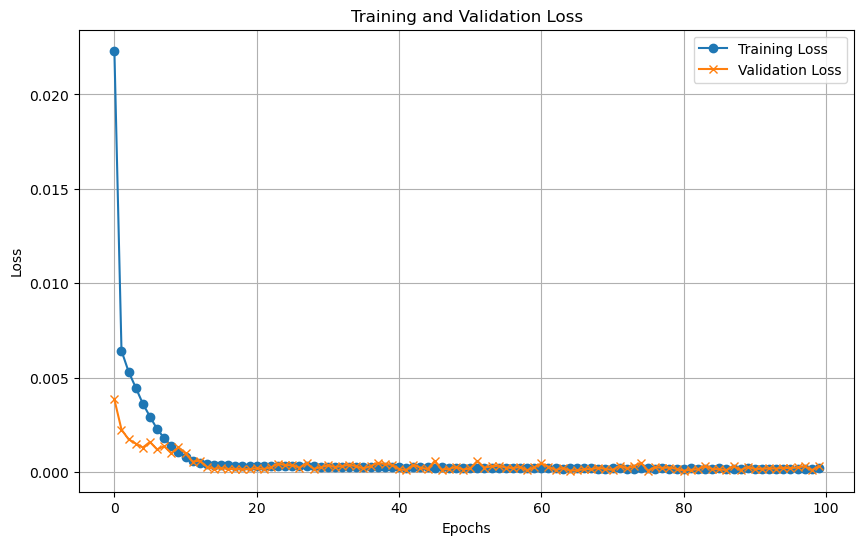

In [65]:
stock.loss()

In [66]:
stock.train(train_loader, valid_loader, test_loader, 'test')

Average Test Loss: 0.0018002018500977244


c:\Users\woora\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\woora\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [67]:
pred, act=stock.pred_value('origin')

In [68]:
stock.diff()

최대 :  [3000.] 최소 :  [100.] 평균:  [799.65753]


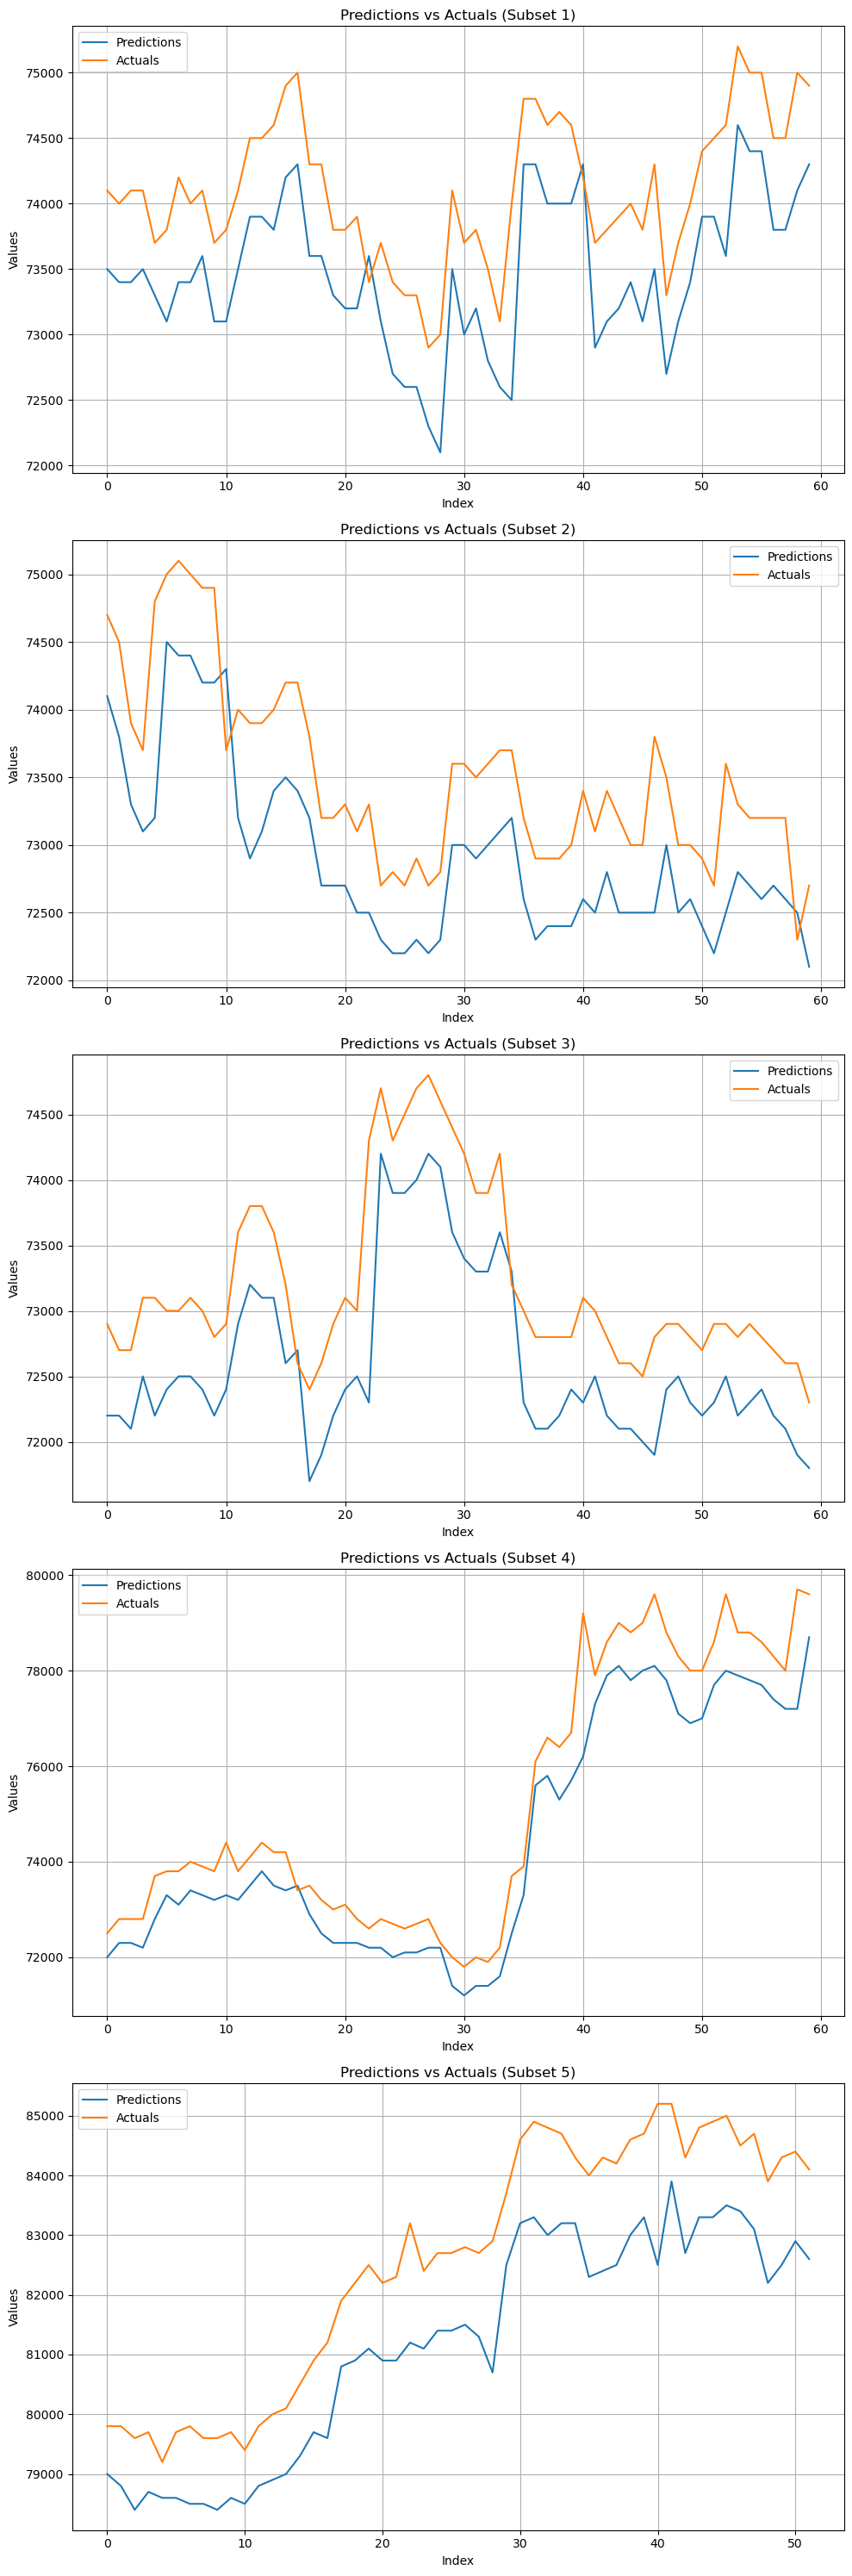

In [69]:
stock.show('origin')

# 수익률 계산 부분

In [105]:
name='almac'

In [106]:
if name=='삼성':
    df_get=pd.read_csv('samsung_m.csv')
    df_pred=pd.read_csv('samsung_h.csv')
if name=='SK':
    df_get=pd.read_csv('hynix_m.csv')
    df_pred=pd.read_csv('hynix_h.csv')
if name=='almac':
    df_get=pd.read_csv('almac_m.csv')
    df_pred=pd.read_csv('almac_h.csv')
#선택된 종목
if name=='mico':
    df_get=pd.read_csv('strong_up_mico_m.csv')
    df_pred=pd.read_csv('strong_up_mico_h.csv')
if name=='polarisAI':
    df_get=pd.read_csv('weak_up_polarisAI_m.csv')
    df_pred=pd.read_csv('weak_up_polarisAI_h.csv')
if name=='hansinmecha':
    df_get=pd.read_csv('horizonal_hansinmecha_m.csv')
    df_pred=pd.read_csv('horizonal_hansinmecha_h.csv.csv')
if name=='gaonchips':
    df_get=pd.read_csv('weak_down_gaonchips_m.csv')
    df_pred=pd.read_csv('weak_down_gaonchips_h.csv')
if name=='studiomyre':
    df_get=pd.read_csv('strong_down_studiomyre_m.csv')
    df_pred=pd.read_csv('strong_down_studiomyre_h.csv')

In [107]:
stock.df=df_pred.copy()

In [108]:
df_pred=stock.preprocessing()

In [109]:
stock.add_col()

,Open,High,Low,Close,Volume,change,target
Datetime,,,,,,,
2024-04-17 09:00:00,34100.0,35200.0,34100.0,34750.0,6899.4,0,0
2024-04-17 10:00:00,34750.0,34800.0,34300.0,34750.0,3833.0,0,0
2024-04-17 11:00:00,34700.0,36000.0,34700.0,34950.0,8295.0,200,1
2024-04-17 12:00:00,34950.0,35800.0,34900.0,35450.0,1617.0,500,1
2024-04-17 13:00:00,35400.0,36300.0,35350.0,36250.0,5465.0,800,1
...,...,...,...,...,...,...,...
2024-05-03 10:00:00,42100.0,47150.0,41700.0,45050.0,795898.0,2900,1
2024-05-03 11:00:00,45000.0,48200.0,44600.0,47400.0,440130.0,2350,1
2024-05-03 12:00:00,47350.0,47800.0,46550.0,47350.0,164348.0,-50,-1


In [110]:
stock.scale_col(stock.df.columns[[0,1,2,5,4,3]]) # 종가

In [111]:
test_loader=stock.data_loader(7, 'test')

In [112]:
stock.create_model()

In [113]:
stock.train(train_loader, valid_loader, test_loader, 'test')

Average Test Loss: 1.1238203048706055


c:\Users\woora\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [114]:
pred, act=stock.pred_value('t')

In [115]:
stock.diff()

최대 :  [15500.] 최소 :  [15400.] 평균:  [15455.38461538]


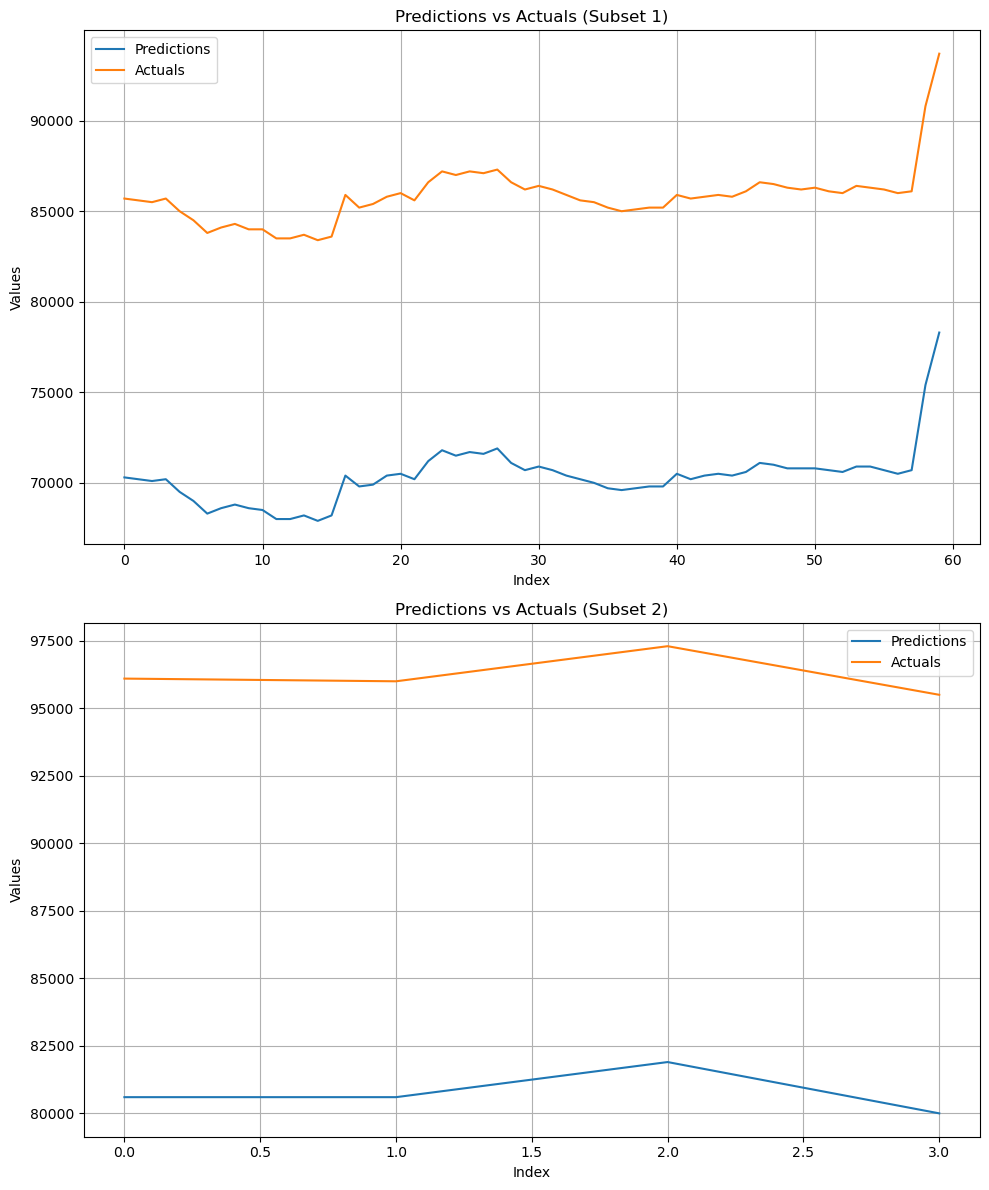

In [116]:
stock.show('chg')

In [117]:
stock.df=df_get.copy()
df_get=stock.preprocessing()

In [118]:
df_pred['pred']=0

In [119]:
df_pred.iloc[len(df_pred)-len(pred):,-1]=pred

In [120]:
df_get['key']=pd.to_datetime(df_get.index).strftime('%m-%H')
df_pred['key']=pd.to_datetime(df_pred.index).strftime('%m-%H')

In [121]:
df_get.loc[:,'pred']=pd.merge(df_get[['key']], df_pred[['key', 'pred']], how='left', on='Datetime')['pred']
df_get.fillna(method='ffill', inplace=True)

C:\Users\woora\AppData\Local\Temp\ipykernel_28764\432936643.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_get.fillna(method='ffill', inplace=True)


In [122]:
df_get[pd.to_datetime(df_get.index).strftime('%M')=='00']

,Open,High,Low,Close,Volume,key,pred
Datetime,,,,,,,
2024-04-24 09:00:00,37600.0,38000.0,37550.0,38000.0,2244.6,04-09,71200.0
2024-04-24 10:00:00,37950.0,37950.0,37900.0,37900.0,128.0,04-10,71800.0
2024-04-24 11:00:00,38550.0,38600.0,38450.0,38450.0,1532.0,04-11,71500.0
2024-04-24 12:00:00,38250.0,38250.0,38250.0,38250.0,61.0,04-12,71700.0
2024-04-24 14:00:00,38400.0,38400.0,38400.0,38400.0,6.0,04-14,71900.0
2024-04-25 09:00:00,39350.0,39450.0,38700.0,39350.0,4412.0,04-09,71100.0
2024-04-25 10:00:00,37900.0,37900.0,37750.0,37750.0,40.0,04-10,70700.0
2024-04-25 11:00:00,37500.0,37500.0,37500.0,37500.0,50.4,04-11,70900.0
2024-04-25 12:00:00,37650.0,37650.0,37650.0,37650.0,93.6,04-12,70700.0


이평선

In [130]:
param_4H = 24
param_8H = 48

df_get['4H_MA'] = df_get['Close'].rolling(window=param_4H).mean()
df_get['8H_MA'] = df_get['Close'].rolling(window=param_8H).mean()

# 이전 행의 4H_MA와 8H_MA 비교를 위해 shift() 사용
df_get['Previous_4H_MA'] = df_get['4H_MA'].shift(1)
df_get['Previous_8H_MA'] = df_get['8H_MA'].shift(1)

# 매수 조건: 이전 4H_MA <= 이전 8H_MA 이고 현재 4H_MA > 현재 8H_MA
df_get['Buy_Signal'] = (df_get['Previous_4H_MA'] <= df_get['Previous_8H_MA']) & (df_get['4H_MA'] > df_get['8H_MA'])

# 매도 조건: 각 시간대의 마지막 분(59분)에 매도
# df_get['Sell_Signal'] = pd.to_datetime(df_get.index).minute == 59
df_get['Sell_Signal'] = (df_get['Previous_4H_MA'] >= df_get['Previous_8H_MA']) & (df_get['4H_MA'] < df_get['8H_MA'])

results=[]
moneys=[]
money=[]
first=[]
key=False
for i, row in df_get.iterrows():
    if row['Buy_Signal'] and row['Open']<=row['pred']:
        money.append(row['Open'])
        key=True
    if (row['Sell_Signal'] or row['Open']>row['pred']) and key:
        results.append((row['Close']-money[0])/money[0]*100)
        moneys.append(row['Close']-money[0])
        first.append(money[0])
        money=[]
        key=False

print(f'모델 수익률: {round(sum(moneys)/first[0]*100, 3)}%')
print(f'모델 수익: {int(sum(moneys))}')
print(f'수수료 포함 수익률: {round(sum(moneys)/first[0]*100-len(moneys)*0.2,3)}%')
print(f'buy & hold 수익률: {round((df_get.iloc[-1,3]-df_get.iloc[0,0])/df_get.iloc[0,0]*100, 3)}%')
print(f'buy & hold 수익: {int(df_get.iloc[-1,3]-df_get.iloc[0,0])}')
print(f'매매횟수: {len(moneys)}')

모델 수익률: 20.105%
모델 수익: 7650
수수료 포함 수익률: 15.905%
buy & hold 수익률: 24.468%
buy & hold 수익: 9200
매매횟수: 21


In [135]:
import pandas as pd
import numpy as np
from deap import base, creator, tools, algorithms
import random

def evaluate(params):
    param_4H, param_8H = params

    # 이동평균 계산
    df_get['4H_MA'] = df_get['Close'].rolling(window=param_4H).mean()
    df_get['8H_MA'] = df_get['Close'].rolling(window=param_8H).mean()
    df_get['Previous_4H_MA'] = df_get['4H_MA'].shift(1)
    df_get['Previous_8H_MA'] = df_get['8H_MA'].shift(1)
    df_get['Buy_Signal'] = (df_get['Previous_4H_MA'] <= df_get['Previous_8H_MA']) & (df_get['4H_MA'] > df_get['8H_MA'])
    df_get['Sell_Signal'] = (df_get['Previous_4H_MA'] >= df_get['Previous_8H_MA']) & (df_get['4H_MA'] < df_get['8H_MA'])

    results = []
    moneys = []
    first = []
    money = []
    key = False

    for i, row in df_get.iterrows():
        if row['Buy_Signal'] and row['Open'] <= row['pred']:
            money.append(row['Open'])
            key = True
        if (row['Sell_Signal'] or row['Open'] > row['pred']) and key:
            results.append((row['Close'] - money[0]) / money[0] * 100)
            moneys.append(row['Close'] - money[0])
            first.append(money[0])
            money = []
            key = False

    if first:  # if first is not empty
        score = round(sum(moneys) / first[0] * 100 - len(moneys) * 0.2, 3)
    else:
        score = 0  # or some default value if first is empty

    return score,

# deap 설정
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# 유전자 변형에 사용될 기본 도구 설정
toolbox.register("attr_param_4H", random.randrange, 4, 50, 2)
toolbox.register("attr_param_8H", random.randrange, 24, 100, 2)

# 유전자의 조합으로 개체를 생성하는 방법 설정
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_param_4H, toolbox.attr_param_8H), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 평가 함수 및 교배, 돌연변이, 선택 연산 정의
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=[4, 24], up=[50, 100], indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# 초기 개체군 생성
population = toolbox.population(n=50)

# GA 실행 설정
NGEN = 50  # Number of generations
CXPB = 0.5  # Crossover probability
MUTPB = 0.2  # Mutation probability

# 알고리즘 실행
for gen in range(NGEN):
    # 개체 평가
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = toolbox.map(toolbox.evaluate, offspring)

    # 적합도 저장
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    # 다음 세대 선택
    population = toolbox.select(offspring, k=len(population))

# 최적 해 도출
best_ind = tools.selBest(population, 1)[0]
print('Best individual:', best_ind)
print('Best fitness:', best_ind.fitness.values[0])


c:\Users\woora\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\woora\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Best individual: [22, 54]
Best fitness: 19.79


In [136]:
param_4H = best_ind[0]
param_8H = best_ind[1]

df_get['4H_MA'] = df_get['Close'].rolling(window=param_4H).mean()
df_get['8H_MA'] = df_get['Close'].rolling(window=param_8H).mean()

# 이전 행의 4H_MA와 8H_MA 비교를 위해 shift() 사용
df_get['Previous_4H_MA'] = df_get['4H_MA'].shift(1)
df_get['Previous_8H_MA'] = df_get['8H_MA'].shift(1)

# 매수 조건: 이전 4H_MA <= 이전 8H_MA 이고 현재 4H_MA > 현재 8H_MA
df_get['Buy_Signal'] = (df_get['Previous_4H_MA'] <= df_get['Previous_8H_MA']) & (df_get['4H_MA'] > df_get['8H_MA'])

# 매도 조건: 각 시간대의 마지막 분(59분)에 매도
# df_get['Sell_Signal'] = pd.to_datetime(df_get.index).minute == 59
df_get['Sell_Signal'] = (df_get['Previous_4H_MA'] >= df_get['Previous_8H_MA']) & (df_get['4H_MA'] < df_get['8H_MA'])

results=[]
moneys=[]
money=[]
first=[]
key=False
for i, row in df_get.iterrows():
    if row['Buy_Signal'] and row['Open']<=row['pred']:
        money.append(row['Open'])
        key=True
    if (row['Sell_Signal'] or row['Open']>row['pred']) and key:
        results.append((row['Close']-money[0])/money[0]*100)
        moneys.append(row['Close']-money[0])
        first.append(money[0])
        money=[]
        key=False

print(f'모델 수익률: {round(sum(moneys)/first[0]*100, 3)}%')
print(f'모델 수익: {int(sum(moneys))}')
print(f'수수료 포함 수익률: {round(sum(moneys)/first[0]*100-len(moneys)*0.2,3)}%')
print(f'buy & hold 수익률: {round((df_get.iloc[-1,3]-df_get.iloc[0,0])/df_get.iloc[0,0]*100, 3)}%')
print(f'buy & hold 수익: {int(df_get.iloc[-1,3]-df_get.iloc[0,0])}')
print(f'매매횟수: {len(moneys)}')

모델 수익률: 23.39%
모델 수익: 8900
수수료 포함 수익률: 19.79%
buy & hold 수익률: 24.468%
buy & hold 수익: 9200
매매횟수: 18


## 변동성

In [124]:
k = 0.8

df_pred['Point']=(df_pred['High'].shift(1)-df_pred['Low'].shift(1))*k+df_pred['Open']
df_pred['Point2']=-(df_pred['High'].shift(1)-df_pred['Low'].shift(1))*k+df_pred['Open']
df_get['Point']=pd.merge(df_get[['key']], df_pred[['key', 'Point']], how='left', on='Datetime')['Point']
df_get['Point2']=pd.merge(df_get[['key']], df_pred[['key', 'Point2']], how='left', on='Datetime')['Point2']
df_get['Point'].fillna(method='ffill', inplace=True)
df_get['Point2'].fillna(method='ffill', inplace=True)

df_get['Buy_Signal'] = (df_get['Point'] <= df_get['Open'])
df_get['Sell_Signal'] = (df_get['Point2'] >= df_get['Open'])
# df_get['Sell_Signal'] = pd.to_datetime(df_get.index).minute == 59

moneys=[]
money=[]
first=[]
key=False
for i, row in df_get.iterrows():
    if row['Buy_Signal'] and row['Open']<=row['pred']:
        money.append(row['Open'])
        key=True
    if (row['Sell_Signal'] or row['Open']>row['pred']) and key:
        moneys.append(row['Close']-money[0])
        first.append(money[0])
        money=[]
        key=False
print(f'모델 수익률: {round(sum(moneys)/first[0]*100, 3)}%')
print(f'모델 수익: {int(sum(moneys))}')
print(f'수수료 포함 수익률: {round(sum(moneys)/first[0]*100-len(moneys)*0.2,3)}%')
print(f'buy & hold 수익률: {round((df_get.iloc[-1,3]-df_get.iloc[0,0])/df_get.iloc[0,0]*100, 3)}%')
print(f'buy & hold 수익: {int(df_get.iloc[-1,3]-df_get.iloc[0,0])}')
print(f'매매횟수: {len(moneys)}')

C:\Users\woora\AppData\Local\Temp\ipykernel_28764\2091973111.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_get['Point'].fillna(method='ffill', inplace=True)
C:\Users\woora\AppData\Local\Temp\ipykernel_28764\2091973111.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_get['Point2'].fillna(method='ffill', inplace=True)


8350.0

In [126]:
import pandas as pd
import numpy as np
from deap import base, creator, tools, algorithms
import random

def calculate_profit(k):
    df_pred['Point'] = (df_pred['High'].shift(1) - df_pred['Low'].shift(1)) * k + df_pred['Open']
    df_pred['Point2'] = -(df_pred['High'].shift(1) - df_pred['Low'].shift(1)) * k + df_pred['Open']

    df_get['Point'] = pd.merge(df_get[['key']], df_pred[['key', 'Point']], how='left', on='Datetime')['Point']
    df_get['Point2'] = pd.merge(df_get[['key']], df_pred[['key', 'Point2']], how='left', on='Datetime')['Point2']
    df_get['Point'].fillna(method='ffill', inplace=True)
    df_get['Point2'].fillna(method='ffill', inplace=True)

    df_get['Buy_Signal'] = (df_get['Point'] <= df_get['Open'])
    df_get['Sell_Signal'] = (df_get['Point2'] >= df_get['Open'])

    moneys = []
    money = []
    key = False
    for i, row in df_get.iterrows():
        if row['Buy_Signal'] and row['Open'] <= row['pred']:
            money.append(row['Open'])
            key = True
        if (row['Sell_Signal'] or row['Open'] > row['pred']) and key:
            moneys.append(row['Close'] - money[0])
            money = []
            key = False

    total_profit = sum(moneys)
    return total_profit


# DEAP 설정
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_one_max(individual):
    k = individual[0]
    profit = calculate_profit(k)
    return profit,

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", eval_one_max)

# 유전 알고리즘 매개변수
population = toolbox.population(n=50)
ngen = 40
cxpb = 0.5
mutpb = 0.2

# 유전 알고리즘 실행
result, log = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, verbose=False)

# 최적의 개체 추출
best_ind = tools.selBest(population, 1)[0]
optimal_k = best_ind[0]
print(f'Optimal k: {optimal_k}')
print(f'Maximum profit: {best_ind.fitness.values[0]}')


c:\Users\woora\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\woora\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\woora\AppData\Local\Temp\ipykernel_28764\727861684.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_get['Point'].fillna(method='ffill', inplace=True)
C:\Users\woora\AppData\Local\Temp\ipykernel_28764\727861684.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future vers

Optimal k: 0.9544430205805556
Maximum profit: 9550.0


In [128]:
k = optimal_k

df_pred['Point']=(df_pred['High'].shift(1)-df_pred['Low'].shift(1))*k+df_pred['Open']
df_pred['Point2']=-(df_pred['High'].shift(1)-df_pred['Low'].shift(1))*k+df_pred['Open']
df_get['Point']=pd.merge(df_get[['key']], df_pred[['key', 'Point']], how='left', on='Datetime')['Point']
df_get['Point2']=pd.merge(df_get[['key']], df_pred[['key', 'Point2']], how='left', on='Datetime')['Point2']
df_get['Point'].fillna(method='ffill', inplace=True)
df_get['Point2'].fillna(method='ffill', inplace=True)

df_get['Buy_Signal'] = (df_get['Point'] <= df_get['Open'])
df_get['Sell_Signal'] = (df_get['Point2'] >= df_get['Open'])
# df_get['Sell_Signal'] = pd.to_datetime(df_get.index).minute == 59

moneys=[]
money=[]
first=[]
key=False
for i, row in df_get.iterrows():
    if row['Buy_Signal'] and row['Open']<=row['pred']:
        money.append(row['Open'])
        key=True
    if (row['Sell_Signal'] or row['Open']>row['pred']) and key:
        moneys.append(row['Close']-money[0])
        first.append(money[0])
        money=[]
        key=False
print(f'모델 수익률: {round(sum(moneys)/first[0]*100, 3)}%')
print(f'모델 수익: {int(sum(moneys))}')
print(f'수수료 포함 수익률: {round(sum(moneys)/first[0]*100-len(moneys)*0.2,3)}%')
print(f'buy & hold 수익률: {round((df_get.iloc[-1,3]-df_get.iloc[0,0])/df_get.iloc[0,0]*100, 3)}%')
print(f'buy & hold 수익: {int(df_get.iloc[-1,3]-df_get.iloc[0,0])}')
print(f'매매횟수: {len(moneys)}')

모델 수익률: 25.132%
모델 수익: 9550
수수료 포함 수익률: 24.332%
buy & hold 수익률: 24.468%
buy & hold 수익: 9200
매매횟수: 4


C:\Users\woora\AppData\Local\Temp\ipykernel_28764\3374149426.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_get['Point'].fillna(method='ffill', inplace=True)
C:\Users\woora\AppData\Local\Temp\ipykernel_28764\3374149426.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_get['Point2'].fillna(method='ffill', inplace=True)
